In [1]:
!nvidia-smi

Wed Jul 16 20:26:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fake-and-real-news-dataset


In [4]:
true_csv_path = "/kaggle/input/fake-and-real-news-dataset/True.csv"
fake_csv_path = "/kaggle/input/fake-and-real-news-dataset/Fake.csv"

In [5]:
import pandas as pd
import numpy as np

In [6]:
true_df = pd.read_csv(true_csv_path)
fake_df = pd.read_csv(fake_csv_path)
true_df.loc[0][['title']]

,0
title,"As U.S. budget fight looms, Republicans flip t..."


In [7]:
fake_df.sample(5)

,title,text,subject,date
21951,"Smart Cities, Androids, Technocracy, Kevin Spa...",Tune in to the Alternate Current Radio Network...,US_News,"November 3, 2017"
2930,"Internet Hilariously Mocks Trump’s Pathetic, ...",Trump s inauguration crowd size was pathetic. ...,News,"January 20, 2017"
17401,BREAKING: HILLARY CLINTON’S STATE DEPARTMENT G...,IF SHE S NOT TOAST NOW THEN WE RE IN BIGGER TR...,Government News,"Apr 23, 2015"
12594,BREAKING: CLINTON CHAIRMAN’S SISTER-IN-LAW Lob...,Amid the tumult of the 2016 presidential campa...,politics,"Oct 28, 2016"
22329,LAME DUCK: New Obama Executive Action Opens Do...,Patrick Henningsen 21st Century Wire As 21WIRE...,US_News,"December 8, 2016"


In [8]:
true_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [9]:
true_df['target'] = 1
fake_df['target'] = 0

In [10]:
true_df.drop(columns = ['title','subject','date'],inplace=True)
fake_df.drop(columns = ['title','subject','date'],inplace=True)

In [11]:
df = pd.concat([true_df,fake_df],ignore_index=True)
df

,text,target
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1
...,...,...
44893,21st Century Wire says As 21WIRE reported earl...,0
44894,21st Century Wire says It s a familiar theme. ...,0
44895,Patrick Henningsen 21st Century WireRemember ...,0
44896,21st Century Wire says Al Jazeera America will...,0


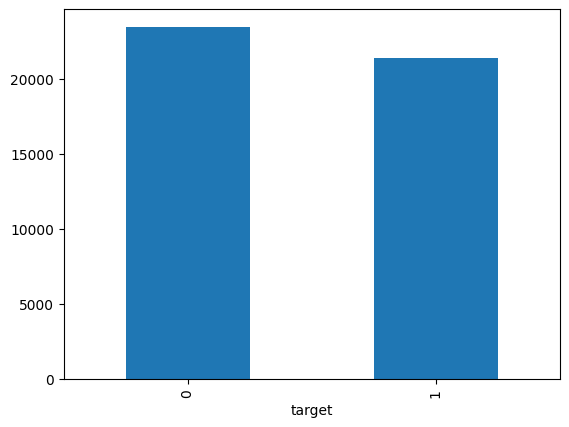

In [12]:
value_counts = df['target'].value_counts().plot(kind='bar')

In [13]:
# checking for the null values
df.isnull().sum()

,0
text,0
target,0


In [14]:
df.duplicated().sum()

np.int64(6251)

In [15]:
# there are 6251 duplicate values in it
# removing duplicated rows
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

### Creating train_test split

In [16]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val= train_test_split(df['text'],df['target'],test_size=0.3,random_state=42,shuffle=True)
x_val,x_test,y_val,y_test = train_test_split(x_val,y_val,test_size=0.15,random_state=42,shuffle=True)
x_train.shape,y_train.shape,x_val.shape,y_val.shape,x_test.shape,y_test.shape

((27052,), (27052,), (9855,), (9855,), (1740,), (1740,))

In [17]:
# checking if the true and fake new are well mixed or not
# if they the training data has only one target variable more than the model predictions will affect

y_train.value_counts(),y_val.value_counts(),y_test.value_counts()

(target
 1    14820
 0    12232
 Name: count, dtype: int64,
 target
 1    5405
 0    4450
 Name: count, dtype: int64,
 target
 1    967
 0    773
 Name: count, dtype: int64)

## Creating a Baseline Model

### MultinomialNB

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("tfidf",TfidfVectorizer()),
    ("nb", MultinomialNB())
])

model.fit(x_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('nb', MultinomialNB())])

In [19]:
model.score(x_val,y_val)


0.9374936580416032

In [20]:
model.score(x_test,y_test)


0.9379310344827586

## Data Preprocessing

In [21]:
# first 30 words before preprocessing
array = []
count = 0
for words in x_train.iloc[0].split(" "):
    array.append(words)
    count+=1
    if count>30:
        break
print(" ".join(array))


Donald Trump continued escalating his rhetoric on nuclear weapons Wednesday morning in a boast that should concern every American.The reality of a potential nuclear holocaust hasn t been this worrisome since


In [22]:
import re

def process(text):
    text = text.lower()

    text = re.sub('[^a-zA-Z]'," ",text)
    text = re.sub('\s+'," ",text)
    text = re.sub(r'https?://\S+|www\.\S+|[^a-zA-Z\s]', '', text)
    text = re.sub(r"<.*?>","",text)

    return text

In [23]:
# use np.vectorize to apply function to all instead of writing a loop
vectorized = np.vectorize(process)
x_train = vectorized(x_train)
x_val = vectorized(x_val)
x_test = vectorized(x_test)

In [24]:
" ".join(x_train[0].split(" ")[:30])

'donald trump continued escalating his rhetoric on nuclear weapons wednesday morning in a boast that should concern every american the reality of a potential nuclear holocaust hasn t been this'

### Tokenizer and padding

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Adding tokenizer first fit it to the data and then transform the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)
x_test = tokenizer.texts_to_sequences(x_test)

In [26]:
max_vocab = len(tokenizer.word_index) + 1
max_length = max(len(d) for d in x_train)

In [27]:
x_train = pad_sequences(x_train,maxlen=max_length,padding='post',truncating='post')
x_val = pad_sequences(x_val,maxlen=max_length,padding='post',truncating='post')
x_test = pad_sequences(x_test,maxlen=max_length,padding='post',truncating='post')

In [28]:
max_length,max_vocab

(8281, 96735)

## Creating model

In [29]:
# creating earlystopping and learning rate changer
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

earlystopping = EarlyStopping(monitor='val_loss',patience=2,
                          restore_best_weights=True,mode='min')
reducelr = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=1,mode='min')

In [30]:
from tensorflow.keras import layers
model_1 = tf.keras.Sequential([
    layers.Input(shape=(max_length,)),
    layers.Embedding(max_vocab,300,input_length=max_length,trainable=False),

    # add rnn
    layers.Bidirectional(layers.LSTM(128,return_sequences=True)),
    layers.Bidirectional(layers.LSTM(64)),

    layers.Dropout(0.2),

    layers.Dense(256,activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(1,activation='sigmoid')
])

In [31]:
model_1.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

history_1 = model_1.fit(
    x_train,
    y_train,
    epochs=10,
    validation_data=(x_val,y_val),
    callbacks=[earlystopping,reducelr]
)

Epoch 1/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 1066s 1s/step - accuracy: 0.9319 - loss: 0.1324 - val_accuracy: 0.9918 - val_loss: 0.0475 - learning_rate: 0.0010
Epoch 2/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 1068s 1s/step - accuracy: 0.9916 - loss: 0.0483 - val_accuracy: 0.9944 - val_loss: 0.0364 - learning_rate: 0.0010
Epoch 3/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 1043s 1s/step - accuracy: 0.9888 - loss: 0.0600 - val_accuracy: 0.9770 - val_loss: 0.0808 - learning_rate: 0.0010
Epoch 4/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 1038s 1s/step - accuracy: 0.9912 - loss: 0.0395 - val_accuracy: 0.9983 - val_loss: 0.0103 - learning_rate: 2.0000e-04
Epoch 5/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 1041s 1s/step - accuracy: 0.9972 - loss: 0.0165 - val_accuracy: 0.9984 - val_loss: 0.0082 - learning_rate: 2.0000e-04
Epoch 6/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 1024s 1s/step - accuracy: 0.9973 - loss: 0.0162 - val_accuracy: 0.9985 - val_loss: 0.0080 - learning_rate: 2.0000e-04
Epoch 7/10
846/846 ━━━━━━━━━━━━━━━━━━━━ 1041s 1s/step - accuracy

In [33]:
model_1.save("my_model.keras")

In [35]:
from sklearn.metrics import accuracy_score
train_preds = tf.round(model_1.predict(x_train))
val_preds = tf.round(model_1.predict(x_val))
test_preds = tf.round(model_1.predict(x_test))


846/846 ━━━━━━━━━━━━━━━━━━━━ 354s 418ms/step
308/308 ━━━━━━━━━━━━━━━━━━━━ 128s 416ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 418ms/step
Train Accuracy : 99.79 %
Test Accuracy  : 99.86 %
Test Accuracy  : 99.77 %


<Axes: >

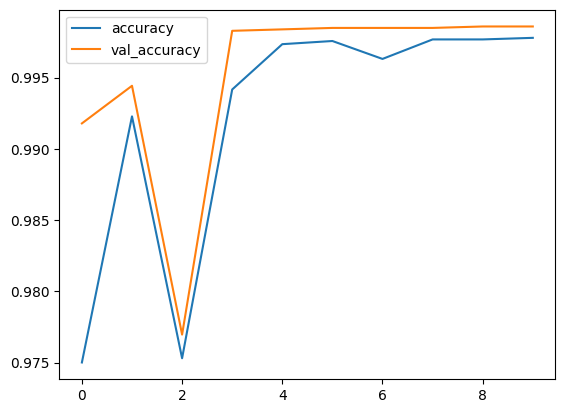

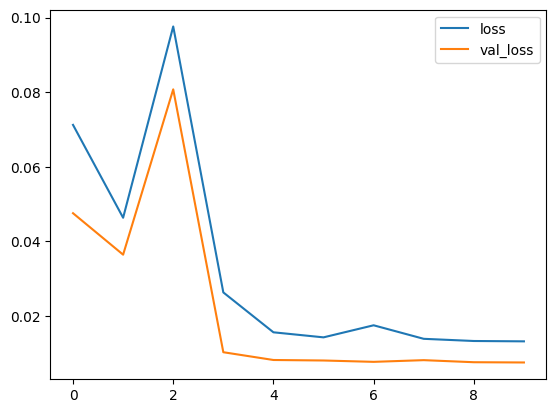

In [34]:
history_df = pd.DataFrame(history_1.history)
history_df.loc[:,['accuracy','val_accuracy']].plot()
history_df.loc[:,['loss','val_loss']].plot()

In [36]:

print(f'Train Accuracy : {accuracy_score(y_train, train_preds) * 100:.2f} %')
print(f'Validation Accuracy  : {accuracy_score(y_val, val_preds) * 100:.2f} %')
print(f'Test Accuracy  : {accuracy_score(y_test, test_preds) * 100:.2f} %')

Train Accuracy : 99.79 %
Validation Accuracy  : 99.86 %
Test Accuracy  : 99.77 %


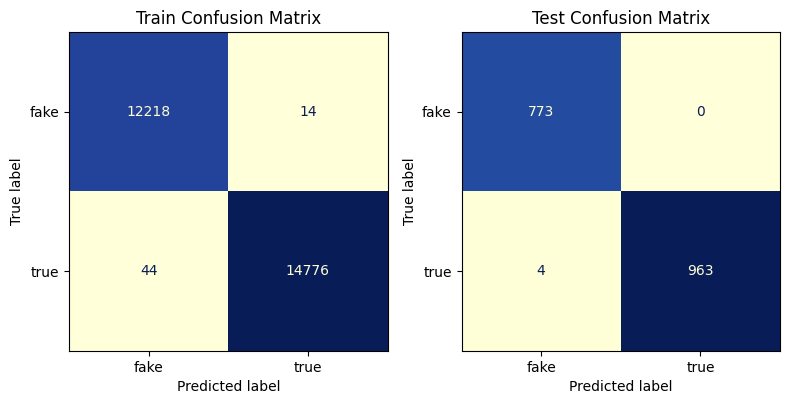

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
train_matrix = confusion_matrix(y_train, train_preds)
test_matrix = confusion_matrix(y_test, test_preds)

class_labels = ['fake', 'true']

disp_train = ConfusionMatrixDisplay(confusion_matrix = train_matrix, display_labels = class_labels)
disp_test = ConfusionMatrixDisplay(confusion_matrix = test_matrix, display_labels = class_labels)

fig, axs = plt.subplots(1, 2, figsize = (8, 12))

# train

disp_train.plot(ax = axs[0], cmap = 'YlGnBu', colorbar = False)
axs[0].set_title('Train Confusion Matrix')

# test

disp_test.plot(ax = axs[1], cmap = 'YlGnBu', colorbar = False)
axs[1].set_title('Test Confusion Matrix')

plt.tight_layout()
plt.show()
